# Case study: Classification of shapes

##### License: AGPLv3


The following notebook explains how to use *giotto* to be able to classify topologically different high-dimensional spaces.

The first step consists in importing the *giotto* library.

In [1]:
# Importing libraries
import giotto as go
import giotto.time_series as ts
import giotto.diagrams as diag
import giotto.homology as hl
from giotto.diagrams import PersistenceEntropy, BettiCurve, PersistenceLandscape, HeatKernel
import numpy as np
import sklearn as sk
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  



# Plotting functions

The *plotting.py* file is required to use the following plotting functions. It can be found in the *examples* folder on out github <https://github.com/giotto-ai/giotto-learn>.

In [2]:
# Plotting functions
from plotting import plot_diagram, plot_landscapes
from plotting import plot_betti_surfaces, plot_betti_curves
from plotting import plot_point_cloud

# Sampling orientable surfaces

We are going to consider three classical topological spaces: the circle, the 2-torus and the 2-sphere.
The purpose of this tutorial is to go thgough the most famous topological spaces and compute their homology groups.

Each of the topological spaces we are going to encounter will be sampled. The resulting point clound will be the input of the *persistent homology pipeline*. The first step is to apply the Vietoris-Rips technique to the point cloud. Finally, the persistent homology groups will be computed.

In [3]:
# Representing the circle in 3d with parametric equations.
circle = np.asarray([[np.sin(t),np.cos(t),0] for t in range(400)])
plot_point_cloud(circle)

In [4]:

# Representing the sphere in 3d with parametric equations
sphere = np.asarray([[np.cos(s)*np.cos(t),np.cos(s)*np.sin(t),np.sin(s)] for t in range(20) for s in range(20)])
plot_point_cloud(sphere)

In [5]:
# Representing the torus in 3d with parametric equations
torus = np.asarray([[(2+np.cos(s))*np.cos(t),(2+np.cos(s))*np.sin(t),np.sin(s)] for t in range(20) for s in range(20)])
plot_point_cloud(torus)


In [6]:
# Saving the results into an array

topological_spaces=np.asarray([circle,sphere,torus])

# Computing persistent homology

In the next section we are using *giotto* to compute the persistent homology groups of the topological spaces we just constructed.
We will use the Vietoris-Rips technique to generate a filtration out of a point cloud:

![SegmentLocal](../chaos_prediction/1w3BiQI1OX93KXcezctRQTQ.gif "segment")

In [7]:

# the homology ranks we choose to consider
homologyDimensions = (0, 1 ,2)
persistenceDiagram = hl.VietorisRipsPersistence(metric='euclidean', max_edge_length=10, 
                                                homology_dimensions=homologyDimensions, 
                                                n_jobs=-1)
persistenceDiagram.fit(topological_spaces)

# List of all the time-pordered persistent diagrams obtained from the list of correlation matrices
Diagrams = persistenceDiagram.transform(topological_spaces)


In [8]:
print(Diagrams.shape)

(3, 865, 3)


# Persistent diagrams

The topological information of the point cloud is synthesised in the persistent diagram. The horizonral axis corresponds to the moment in which an homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.
The generators of the homology groups (at given rank) are colored differently

In [9]:
# plotting the persistent diagram of the circle
plot_diagram(Diagrams[0])

In [10]:
# plotting the persistent diagram of the sphere
plot_diagram(Diagrams[1])

In [11]:
# plotting the persistent diagram of the torus
plot_diagram(Diagrams[2])

# Conclusion of the first part
As you can see from the persistence diagrams, all the betti numbers were found. Some other persistent generators are also appearing, depending on how dense the sampling is and how much noise there is. For example, we see a rahter neat persistent diagram over the Torus bottle (wesee 2 persistent generators for $H^1$ and 1 persistent generator for $H^2$). Notice though that there are other persistent H1 generators, possibly due to the non-uniform sampling method we used for the torus.
On the other hand, the persistent diagram for the circle is as perfect as it could be: one unique generator of $H^1$ and no other persistent generator, as expeceted.


# Classification of noisy orientable surfaces
In the next section we generate hundreds of noisy spheres and noisy tori. The effect of noise is to displace the points sampling the aforementioned surfaces by a random amount in a random direction.
The Vietoris-Rips algorithm is used to compute persistent diagrams. Afterwards, from each diagram, the *persistece entropy* is computed. 
A simple linear classifier is then applied to the 3d-space of entropies to classify shapes.

In [50]:
# building dataset
n_train = 100
n_range = 15
eps = 0.5

train_Xs = [np.asarray([[np.cos(s)*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),np.cos(s)*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
train_ys = np.zeros(n_train)
train_Xt = [np.asarray([[(2+np.cos(s))*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),(2+np.cos(s))*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
train_yt = np.ones(n_train)

# complete training set
train_X = np.concatenate((train_Xs, train_Xt))
train_y = np.concatenate((train_ys, train_yt))

test_Xs = [np.asarray([[np.cos(s)*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),np.cos(s)*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
test_ys = np.zeros(n_train)
test_Xt = [np.asarray([[(2+np.cos(s))*np.cos(t) + eps*(np.random.rand(1)[0]-0.5),(2+np.cos(s))*np.sin(t) + eps*(np.random.rand(1)[0]-0.5),np.sin(s) + eps*(np.random.rand(1)[0] - 0.5)] for t in range(n_range) for s in range(n_range)]) for kk in range(n_train)]
test_yt = np.ones(n_train)


# complete test set
test_X = np.concatenate((test_Xs, test_Xt))
test_y = np.concatenate((test_ys, test_yt))


In [51]:
# build persistent diagrams

# the homology ranks we choose to consider
homologyDimensions = (0, 1, 2)
persistenceDiagram = hl.VietorisRipsPersistence(metric='euclidean', 
                                                max_edge_length=10, 
                                                homology_dimensions=homologyDimensions, 
                                                n_jobs=4)
persistenceDiagram.fit(np.asarray(train_X))

# List of all the time-pordered persistent diagrams obtained from the list of correlation matrices
train_Diagrams = persistenceDiagram.transform(np.asarray(train_X))
test_Diagrams = persistenceDiagram.transform(np.asarray(test_X))


## Extract and plot persistent entropies

In [52]:
# Extract vector features from diagrams: persistence entropy
pe = PersistenceEntropy()
pe.fit(train_Diagrams)
X_train = pe.transform(train_Diagrams)
X_test = pe.transform(test_Diagrams)

In [53]:
plot_point_cloud(X_train)

In [54]:
# training logistic regression
lr = sk.linear_model.LogisticRegression(solver='lbfgs')
lr.fit(X_train, train_y)
# score
lr.score(X_test, test_y)

0.995

# Generating non-orientable surfaces

We are going to consider different classical shapes: the real projective space and the Klein bottle.
The purpose of the second part of the tutorial is to define shapes via a distance matrix. We also add noise to the distace matrix: the main reason is not to have overlapping points in the persistent diagram.

Each of the topological spaces we are going to encounter will be sampled discretely. Aftewards the Vietoris-Rips technique will be applied to the surface and the persistent homology groups will be computed.

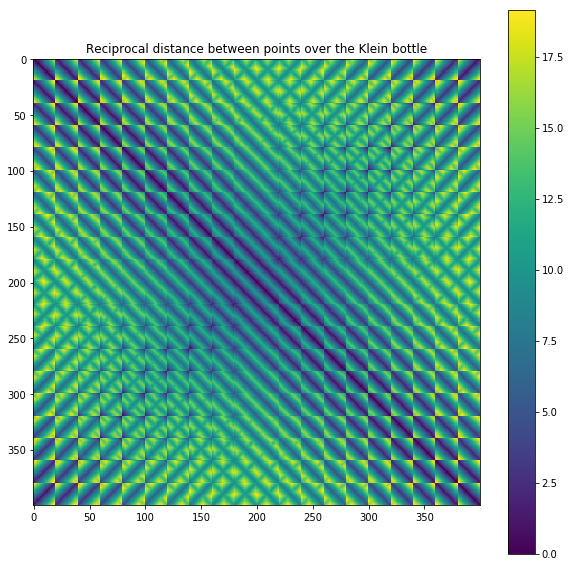

In [110]:
# computing the adjacency matrix of the grid points, with boundaries identified as in the real projective space
from sklearn.utils.graph_shortest_path import graph_shortest_path

# This functions prepares the grid matrix with boundary identification
def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # vertical twisted boundary identification
            if c == 0: M[n-i-1,i] = M[i,n-i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # horizontal twisted boundary identification
            if r == 0: M[n-i-1,i] = M[i,n-i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
                
    return M

M = make_matrix(20,20)

# computing the distance matrix of the points over the Klein bottle

rp2 = graph_shortest_path(M)

# Plot of the distance matrix
figure = plt.figure(figsize=(10,10))
plt.imshow(rp2)
plt.title('Reciprocal distance between points over the Klein bottle')
plt.colorbar()
plt.show()



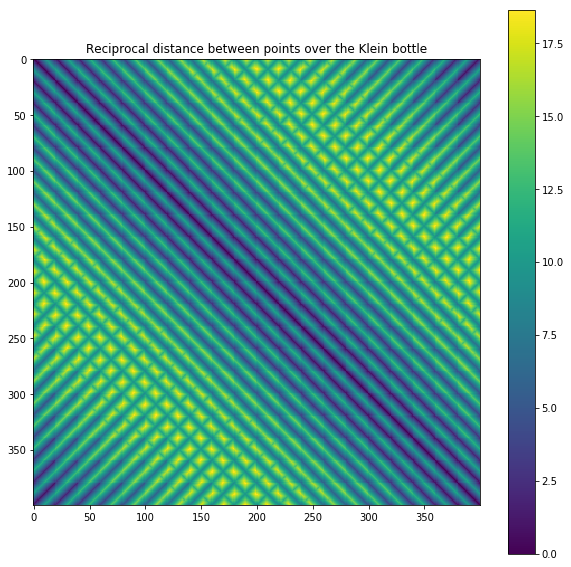

In [111]:
# computing the adjacency matrix of the grid points, with boundaries identified as in the klein bottle
from sklearn.utils.graph_shortest_path import graph_shortest_path

# This functions prepares the grid matrix with boundary identification
def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # vertical boundary identification
            if c == 0: M[i+cols-1,i] = M[i,i+cols-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
            # horizontal twisted boundary identification
            if r == 0: M[n-i-1,i] = M[i,n-i-1] = 1 + 0.15*(np.random.rand(1)[0]-0.5)
                
    return M

M = make_matrix(20,20)

# computing the distance matrix of the points over the Klein bottle

klein = graph_shortest_path(M)

# Plot of the distance matrix
figure = plt.figure(figsize=(10,10))
plt.imshow(klein)
plt.title('Reciprocal distance between points over the Klein bottle')
plt.colorbar()
plt.show()


In [112]:
# Saving the results into an array

topological_spaces_mat=np.asarray([rp2, klein])

# Computing persistent homology

In the next section we are using *giotto* to compute the persistent homology groups of the topological spaces we just constructed

In [113]:

# the homology ranks we choose to consider
homologyDimensions = (0, 1 ,2)
persistenceDiagram = hl.VietorisRipsPersistence(metric='precomputed', max_edge_length=np.inf, homology_dimensions=homologyDimensions, n_jobs=-1)
persistenceDiagram.fit(topological_spaces_mat)

# List of all the time-pordered persistent diagrams obtained from the list of correlation matrices
zDiagrams = persistenceDiagram.transform(topological_spaces_mat)


# Persistent diagrams

The topological information of the point cloud is synthesised in the persistent diagram. The horizonral axis corresponds to the moment in which an homological generator is born, while the vertical axis corresponds to the moments in which an homological generator dies.
The generators of the homology groups (at given rank) are colored differently

In [114]:
# plotting the persistent diagram of the projective space
plot_diagram(zDiagrams[0])

In [115]:
# plotting the persistent diagram of the Klein bottle
plot_diagram(zDiagrams[1])

# Conclusion

As you can see from the persistence diagrams, all the betti numbers were found. 
Some other persistent generators are also appearing, depending on how dense the sampling is and how much noise there is.
For example, we see a rahter neat persistent diagram over the Klein bottle (wesee 2 persistent generators for $H^1$ and 1 persistent generator for $H^2$). Notice that all these homology groups are computed over the field $\mathbb{F}_2$.